# Paitings

## Heatmap

In [1]:
from fastai.vision import *

In [2]:
path = untar_data(URLs.PETS)/'images'

In [3]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [4]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [5]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [7]:
data = get_data(352, 16)

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

In [9]:
m = learn.model.eval();

In [10]:
xb = open_image('13_sept12_86.jpg').data[None].cuda()

In [11]:
from fastai.callbacks.hooks import *

In [12]:
m[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [13]:
def hooked_backward(cat=0):
    with hook_output(m[0][4][0].conv1) as hook_a: 
        with hook_output(m[0][4][0].conv1, grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [14]:
def hooked_backward(cat=36):
    with hook_output(m[0][4][0].conv1) as hook_a: 
        with hook_output(m[0][4][0].conv1, grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [15]:
hook_a,hook_g = hooked_backward()

In [16]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([64, 79, 119])

In [17]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([79, 119])

In [18]:
def show_heatmap(hm):
    _,ax = plt.subplots()
#     xb_im.show(ax)
    ax.imshow(hm, alpha=1, extent=(0,352,352,0),
              interpolation='bilinear');

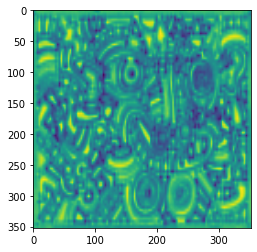

In [19]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [ ]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [ ]:
mult = (acts*grad_chan[...,None,None]).mean(0)

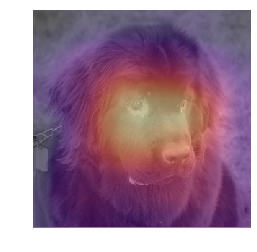

In [ ]:
show_heatmap(mult)

In [ ]:
fn = path/'../other/bulldog_maine.jpg' #Replace with your own image

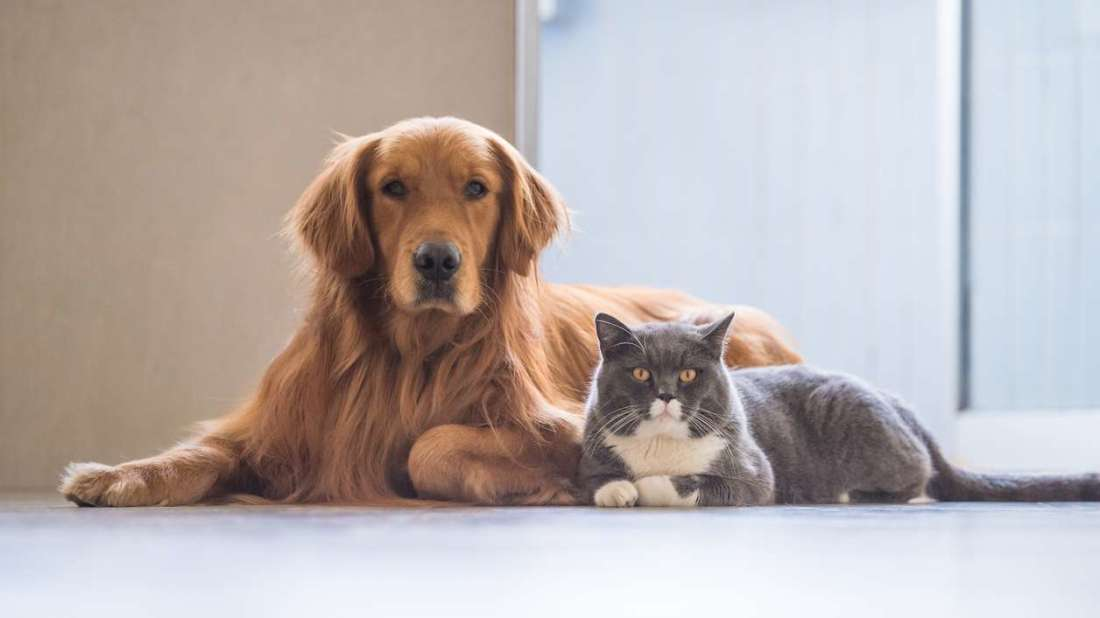

In [ ]:
x = open_image(fn); x

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

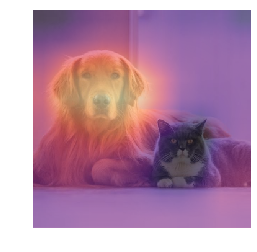

In [ ]:
show_heatmap(mult)

In [ ]:
data.classes[0]

'Abyssinian'

In [ ]:
hook_a,hook_g = hooked_backward(0)

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

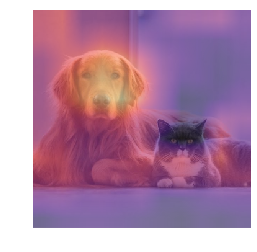

In [ ]:
show_heatmap(mult)

## fin